# Spectral and eigenstate properties of the XXZ spin chain.

Tutorial and Python codes by Nicolas Macé (mace@irsamc.ups-tlse.fr)

The model and parameters used are the ones of https://arxiv.org/abs/1411.0660 (notice that they are **different** from the ones used in the `XXZ_dynamics` notebook; in particular, here we use spin rather than Pauli operators), and the code uses the `quspin` library, see https://arxiv.org/abs/1804.06782.

In [1]:
from quspin.operators import hamiltonian,exp_op,quantum_operator # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.tools.measurements import obs_vs_time, ent_entropy
import numpy as np
import matplotlib.pyplot as plt

### Uncomment if you run into OpenMP issues
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## XXZ Hamiltonian
We study here the XXZ spin chain, in presence of disorder and interactions.
Let us start with routines building the Hamiltonian.
We build the Hamiltonian in two steps: first the clean part H0, which is unchanged from one disorder realization to the other, and then the full Hamiltonian H, including random external fields.

In [2]:
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

def cleanXXZ_operator(L, Delta):
    """
    Return the clean XXZ Hamiltonian with uniform external field set to 1
    Delta: strength of the zz interaction
    """
    Jxy = 1.0 # xy interaction
    basis = spin_basis_1d(L, pauli=0, Nup=L//2) # zero magnetisation sector
    # define operators with OBC using site-coupling lists
    J_zz = [[Delta, i, i+1] for i in range(L-1)] # OBC
    J_pm = [[Jxy/2.0, i, i+1] for i in range(L-1)] # OBC
    # list of the couplings of H0
    operator_list_0 = [["+-",J_pm],["-+",J_pm],["zz",J_zz]]
    # create operator dictionary for quantum_operator class
    operator_dict = dict(H0=operator_list_0)
    # add keys for local potential in each site
    for i in range(L):
        # external fields with dummy value 1 (could be anything except 0)
        operator_dict["z"+str(i)] = [["z",[[1.,i]]]]
    # setting up operator
    H_op = quantum_operator(operator_dict, basis=basis, dtype=np.float64, **no_checks)
    return H_op

def disorderedXXZ_hamiltonian(H0, h, seed):
    """
    Add random external fields to the H0 operator, and return the Hamiltonian.
    """
    state = np.random.RandomState(seed)
    # will hold the on-site potential for each realization
    params_dict = dict(H0=1.0)
    for j in range(H0.basis.L):
        params_dict["z"+str(j)] = state.uniform(-h, h)
    # create the Hamiltonian
    H = H0.tohamiltonian(params_dict)
    return H

## Observables
To probe the ETH/MBL phases, we will use different estimators:
1. The gap ratio, defined as the ratio of two consecutive spectral gaps:
$$
    r_{n} = \min\left(\frac{g_{n+1}}{g_n}, \frac{g_n}{g_{n+1}}\right)
$$
with $g_n = E_{n+1} - E_n$.
1. The half-chain von Neumann entanglement entropy
$$
    S(\psi_n) = -\text{Tr}\left(\rho_n \log \rho_n\right)
$$
with $\psi_n$ the n$^\text{th}$ eigenstate, and $\rho_n$ the corresponding reduced density matrix obtained after tracing over the degrees of freedom in the first half of the chain.
1. The participation entropy
$$
    P(\psi_n) = -\log \sum_\alpha |\langle \alpha | \psi_n \rangle|^4
$$
where $\{| \alpha \rangle\}$ is the computational basis.

Let us start by writing routines to compute these various observables.

In [3]:
def gap_ratios(spec):
    """
    Compute the gap ratios
    """
    # sort
    spec = np.sort(spec)
    # level spacings
    spac = (np.roll(spec,-1) - spec)[:-1]
    # rgaps
    rgap = (np.roll(spac,-1)/spac)[:-1]
    # normalized rgaps
    rgap = np.min([rgap, 1./rgap], axis=0)
    return rgap

def vNM_entropy(states, H0):
    """
    state: a list of states
    Return: Half-chain von Neumann entanglement entropy
    """
    ent = []
    for state in states:
        res = ent_entropy(state, H0.basis)
        ent.append(res['Sent']/np.log(2))
    return ent

def participation_entropy(states):
    return -np.log(np.sum(states**(4.), axis=1))

def do_measurements(H0, H):
    """
    Perform measurements over the whole energy spectrum,
    from full diagonalization of the Hamiltonian
    """
    L = H0.basis.L
    # full diag
    spectrum, P = H.eigh()
    
    rgap = gap_ratios(spectrum)
    ent = vNM_entropy(P.T, H0)
    entp = participation_entropy(P.T)
    return rgap, ent, entp

In [4]:
def get_samples(L, Delta, h, Nsamp):
    """
    Compute the observables for a given number Nsamp of disorder realizations.
    """
    # generate random seeds
    seeds = np.random.randint(0, 10**6., Nsamp)
    # Hamiltonian
    H0 = cleanXXZ_operator(L, Delta)
    # disorder realizations
    Hs = [disorderedXXZ_hamiltonian(H0, h, seed) for seed in seeds]
    obs = zip(*[do_measurements(H0, H) for H in Hs])
    return obs

# Gap ratio distribution
Gap ratios are useful as a quick probe of the phase we are in:
In a chaotic regime, the gap ratios should be distributed according to the random matrix theory compatible with the symmetries of the system (here: Gaussian Orthogonal Ensemble), while in a localized regime, the emergent integrability of the system guarantees Poisson gap ratio statistics.

Here we observe that the $h=0.5$ point is compatible with chaos, while the $h=8$ is compatible with localization.

In [9]:
L = 12
Delta = 1
fields = [0.5, 8]
Nsamp = 20
rgaps = []
for h in fields:
    rgap, ent, entp = get_samples(L, Delta, h, Nsamp)
    rgaps.append(rgap)

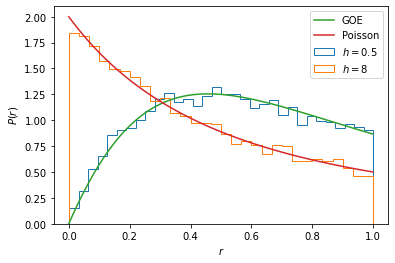

In [10]:
fig, ax = plt.subplots()
# Wigner surmise for the GOE gap ratio distribution [Atas et al, PRL 110, 084101 (2013)]
P_Wigner = lambda r: (27./4.)*(r + r**2.)/(1.+r+r**2.)**(5./2.)
# Poisson gap ratio distribution
P_Poisson = lambda r: 2./(1.+r)**2.
for rgap, h in zip(rgaps, fields):
    ax.hist(np.array(rgap).ravel(),
           histtype='step',
           density=True,
           bins='auto',
           label=f'$h={h}$')
r = np.linspace(0., 1., 100)
ax.plot(r, P_Wigner(r), label='GOE')
ax.plot(r, P_Poisson(r), label='Poisson')
plt.xlabel('$r$')
plt.ylabel('$P(r)$')
plt.legend()
plt.show()

# Phase characterization
Let us now observe how the properties of the system change from thermal to localized as we increaze disorder strength.
To try and quantitatively characterize the localition of the two phases, we compute the various observables for 3 different system sizes. 
As system size is increased, we expect the observables to converge to the thermal (localized) value in the thermal (localized) phase. This will generically lead to a crossing in the region of the transition.

**Warning** the following calculation is expensive and may require 10-20 minutes to run on your laptop. If you wish to skip it, you can load pre-computed data by running the cell below it.

In [11]:
"""
/!\ could take some time to run
"""
sizes = [8, 10, 12]
Delta = 1
fields = np.linspace(0.5, 6, 10)
Nsamp = 50
rgaps, ents, entps = zip(*[zip(*[get_samples(L, Delta, h, Nsamp) for h in fields]) for L in sizes])

KeyboardInterrupt: 

In [12]:
sizes = [8, 10, 12]
Delta = 1
Nsamp = 50
fields = np.loadtxt('data/XXZ/fields.dat')
import pickle
with open('data/XXZ/rgaps.dat', 'rb') as f:
    rgaps = pickle.load(f)
with open('data/XXZ/entps.dat', 'rb') as f:
    entps = pickle.load(f)
with open('data/XXZ/ents.dat', 'rb') as f:
    ents = pickle.load(f)

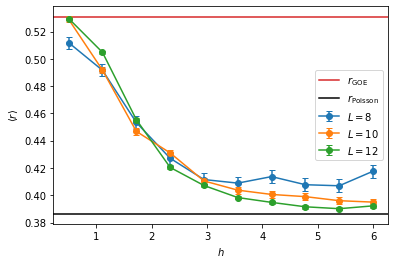

In [13]:
avg_rgaps = [[np.mean(rgapLh) for rgapLh in rgapL] for rgapL in rgaps]
err_rgaps = [[np.std(rgapLh)/np.sqrt(len(np.array(rgapLh).ravel())) for rgapLh in rgapL] for rgapL in rgaps]

fig, ax = plt.subplots()
rGOE, rPoisson = 0.5307, 2*np.log(2)-1
ax.axhline(y=rGOE, label='$r_\mathrm{GOE}$', color='tab:red')
ax.axhline(y=rPoisson, label='$r_\mathrm{Poisson}$', color='k')
for L, avg_rgap, err_rgap in zip(sizes, avg_rgaps, err_rgaps):
    ax.errorbar(fields, avg_rgap, err_rgap,
                fmt='o-',
                capsize=3,
                label=f'$L={L}$')
plt.legend()
plt.xlabel('$h$')
plt.ylabel(r'$\langle r \rangle$')
plt.show()

The von Neumann entropy density goes to 1 in the chaotic regime, and to zero in the localized one.

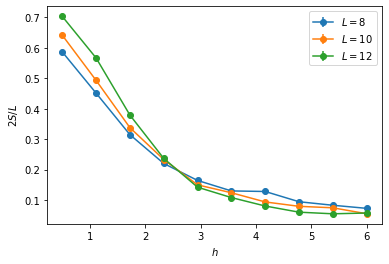

In [14]:
avg_ents = [[np.mean(dataLh) for dataLh in dataL] for dataL in ents]
err_ents = [[np.std(dataLh)/np.sqrt(len(np.array(dataLh).ravel())) for dataLh in dataL] for dataL in ents]

fig, ax = plt.subplots()
for L, avg_ent, err_ent in zip(sizes, avg_ents, err_ents):
    ax.errorbar(fields, avg_ent, err_ent,
                fmt='o-',
                label=f'$L={L}$')
plt.legend()
plt.xlabel('$h$')
plt.ylabel(r'$2 S/ L$')
plt.show()

The participation entropy density (equal to the fractal dimension $D_2$ in the thermodynamic limit) goes to 1 in the chaotic regime, and to some $h$ dependent value strictly smaller than 1 in the MBL regime.

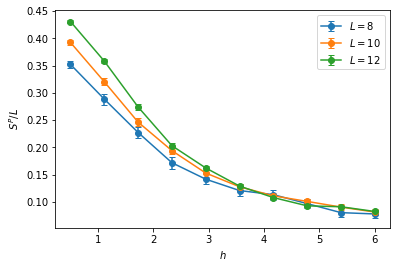

In [17]:
avg_entps = [[np.mean(dataLh) for dataLh in dataL] for dataL in entps]
err_entps = [[np.std(dataLh)/np.sqrt(len(np.array(dataLh).ravel())) for dataLh in dataL] for dataL in entps]

fig, ax = plt.subplots()
for L, avg_entp, err_entp in zip(sizes, avg_entps, err_entps):
    ax.errorbar(fields, np.array(avg_entp)/L, err_entp,
                fmt='o-',
                capsize=3,
                label=f'$L={L}$')
plt.legend()
plt.xlabel('$h$')
plt.ylabel(r'$S^P/L$')
plt.show()

# Mobility edge
In the previous sections, we averaged physical quantities over energy, thus disregarding the possible energy-dependance of the observables.
It turns out, however, that the EHT/MBL occurs at an energy-dependent disorder strength, forming what is called a mobility edge.

In this last part, we compute the energy-resolved average gap ratio to figure out the shape of the mobility edge.
More precisely, we compute the gap ratio as a function of the energy density, defined for the n$^\text{th}$ energy level as
$$
    \epsilon_n = \frac{E_n - E_\text{min}}{E_\text{max} - E_\text{min}}
$$
This quantity has the advantage of being well defined in the thermodynamic limit.

Let us introduce routines to compute the average gap ratio as a function of energy density.

In [18]:
def normalize(spectrum):
    """
    Return: the energy density
    """
    return (spectrum - np.min(spectrum))/(np.max(spectrum) - np.min(spectrum))

def bin_data(spectrum, data, Nb):
    """
    Bin data along the energy axis
    
    data: any energy-sorted observable
    Nb: number of (equal size) energy bins
    
    Return: binned energy densities, binned data
    """
    # energy width of each box
    W = 1./Nb
    # energy density
    Edens = normalize(spectrum)
    bdata, benergies = [[] for ib in range(Nb)], [[] for ib in range(Nb)]
    for e, r in list(zip(Edens, data)):
        ib = int(np.floor(e/W)) # index of the box
        bdata[ib].append(r)
        benergies[ib].append(e)
    return benergies, bdata

def bin_rgaps_samples(L, Delta, h, Nsamp, Nb):
    """
    Compute and bin gap ratios from Nb samples
    Return: average energy density and gap ratio in each bin
    """
    H0 = cleanXXZ_operator(L, Delta)
    # disorder realizations
    seeds = np.random.randint(0, 10**6, Nsamp)
    # global (inter-sample) list of binned rgaps and energies
    br, be = [[] for ib in range(Nb)], [[] for ib in range(Nb)]
    for seed in seeds:
        H = disorderedXXZ_hamiltonian(H0, h, seed)
        # full diag (eigenvalues only)
        spectrum = H.eigvalsh()
        rgaps = gap_ratios(spectrum)
        # bin the current rgaps
        cur_be, cur_br = bin_data(spectrum, rgaps, Nb)
        # append the current binned rgaps to the global list
        for ib in range(Nb):
            be[ib] += cur_be[ib]
            br[ib] += cur_br[ib]
    # return the averages (empty bins being attributed np.nan value)
    return [np.mean(cbe) for cbe in be], [np.mean(cbr) for cbr in br]

We are now ready to compute the gap ratio as a function of energy density and disorder.

**Warning** the following calculation is expensive and may require 10-20 minutes to run on your laptop. If you wish to skip it, you can load pre-computed data by running the cell below it.

In [244]:
"""
/!\ could take some time to run
"""
Nb = 20 # number of energy bins
Nsamp = 200 # number of samples (= disorder realizations)
L = 12
Delta = 1
fields = np.linspace(1, 5, 30)
# averaged binned energy density and gap ratio
be, br = [], []
for h in fields:
    cur_be, cur_br = bin_rgaps_samples(L, Delta, h, Nsamp, Nb)
    be.append(cur_be)
    br.append(cur_br)
    xfields.append(fields)

In [19]:
ldir = 'data/XXZ'
be = np.loadtxt(ldir + '/binned_E_L12.dat')
br = np.loadtxt(ldir + '/binned_rgap_L12.dat')

The closer one gets to density $\epsilon = 0.5$ (corresponding to infinite temperature), the larger the disorder needs to be to enter the MBL regime. Thus, the mobility edge separating the ETH from the MBL region resembles a parabola whose vertex is at $\epsilon = 0.5$.

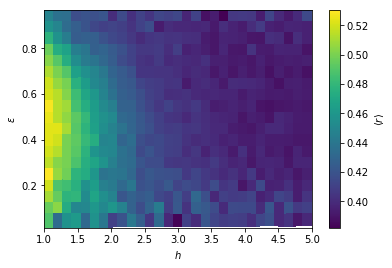

In [20]:
fig, ax = plt.subplots()
Nb = br.shape[-1]
fields = np.linspace(1, 5, 30)
xfields = np.array([fields for _ in range(Nb)]).T
CS = ax.pcolormesh(xfields, be, br, cmap="viridis")
cbar = plt.colorbar(CS)
cbar.set_label(r'$\langle r \rangle$')
plt.xlabel("$h$")
plt.ylabel("$\epsilon$")
plt.show()